In [43]:
%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_palette(sns.color_palette())
from tqdm.notebook import tqdm
from plotnine import *
import pandas as pd

from mizani.palettes import brewer_pal
from palettable import colorbrewer
palette=brewer_pal(type='qual', palette='Set1')

from mcmcmd.samplers import *
from mcmcmd.tests import *

import joblib

In [44]:
rng = onp.random.default_rng(1)
N = 1; p=3
X = rng.normal(size=[N, p])

In [6]:
def run_trial(model, num_samples, bc_burn_in, sc_thinning, alpha, seed):
    num_samples = int(num_samples)
    bc_burn_in = int(bc_burn_in)
    sc_thinning = int(sc_thinning)
    
    num_samples_bc = int(1/(bc_burn_in+2) * num_samples)
    num_samples_sc = int((sc_thinning)/(sc_thinning+1) * num_samples)
    
    num_samples_mc_bc = num_samples_bc
    num_samples_mc_sc = num_samples-num_samples_sc
    num_samples_mc = max(num_samples_mc_bc, num_samples_mc_sc)
    
    model.set_seed(seed)
    samples_mc = model.test_functions(model.sample_mc(num_samples_mc))
    samples_sc = model.test_functions(model.sample_sc(num_samples_sc))[onp.arange(0, num_samples_sc, sc_thinning), :]
    samples_bc = model.test_functions(model.sample_bc(num_samples_bc, bc_burn_in))
    
    rej_ks = ks_test(samples_mc[:num_samples_bc, :], samples_bc)['result'].max()
    
    rej_geweke = geweke_test(samples_mc[:(num_samples-num_samples_sc), :], samples_sc, l=0.08, alpha=alpha)['result'].max()
    
    # Normalize for MMD
    col_mmd = onp.hstack([onp.arange(len(model.theta_indices)),[-2, -1]])
    X_mmd_wb, Y_mmd_wb = normalizeTwoSamples(samples_mc[:(num_samples-num_samples_sc), :][:, col_mmd], samples_sc[:, col_mmd])
    X_mmd, Y_mmd = normalizeTwoSamples(samples_mc[:num_samples_bc, :][:, col_mmd], samples_bc[:, col_mmd])
    
    
    rej_mmd = mmd_test(X_mmd, Y_mmd, rbf_kernel, alpha=alpha, mmd_type='unbiased')['result']        
    rej_mmd_wb = mmd_wb_test(X_mmd_wb, Y_mmd_wb, rbf_kernel, alpha=alpha)['result']
    
    rej_rank = rank_test(model, N=int(num_samples/(bc_burn_in+1)), L=int(bc_burn_in+1))['result'].max()

    return onp.array([rej_ks, rej_geweke, rej_mmd_wb, rej_mmd, rej_rank])

In [ ]:
os.environ['MKL_NUM_THREAD'] = '1'

num_trials = 100
alpha = 0.05

# Same amount of effort
bc_burn_in = 5-1
sc_thinning = 5

lst_experiments = [bayes_lasso_sampler(N=N,p=p,X=X), bayes_lasso_sampler_error_1(N=N,p=p,X=X), bayes_lasso_sampler_error_2(N=N,p=p,X=X)]
lst_sample_size = [3000, 6000, 9000, 12000, 15000, 18000]

lst_res = []

for model in tqdm(lst_experiments):
    for n in tqdm(lst_sample_size):
        num_samples_bc = int(1/(bc_burn_in+2) * n)
        num_samples_sc = int((sc_thinning)/(sc_thinning+1) * n)
        test_size_bc = num_samples_bc
        test_size_sc = n-num_samples_sc
        
        results = joblib.Parallel(n_jobs=5)(joblib.delayed(run_trial)(model, n, bc_burn_in, sc_thinning, alpha, seed) for seed in range(num_trials))
        results = onp.vstack(results).mean(0)
        
       # Convert rejection rate to Type I/II error
        if 'error' in type(model).__name__:
            results = 1-results
        
        lst_test = ['ks', 'geweke', 'mmd_wb', 'mmd', 'rank']
        lst_test_size = [test_size_bc, test_size_sc, test_size_sc, test_size_bc, test_size_bc]
        lst_res.append(pd.DataFrame({'experiment': type(model).__name__, 'test':lst_test,  'test_size':lst_test_size, 'sample_budget':n, 'result':results}))

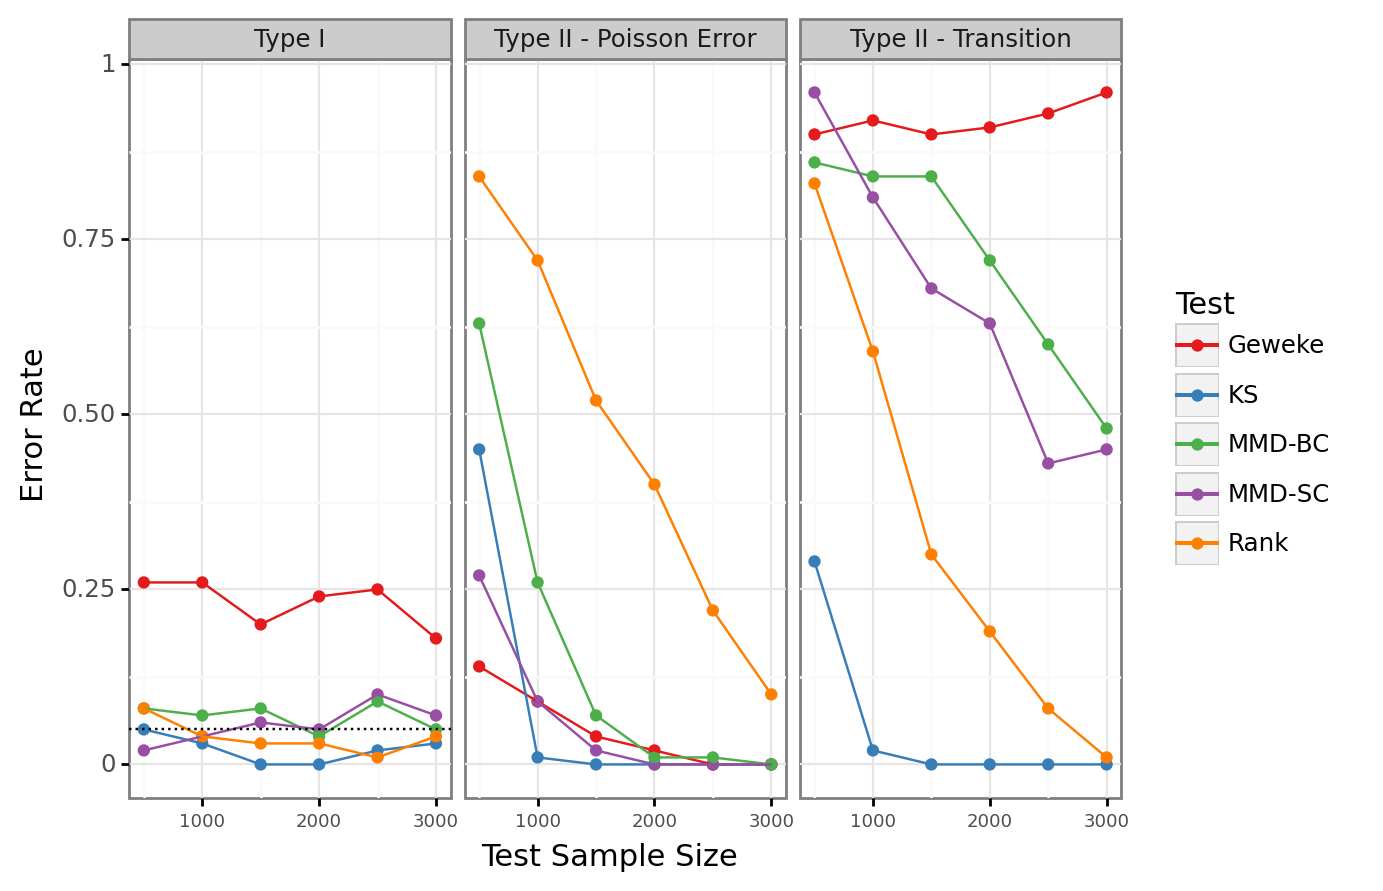

<ggplot: (8774551460292)>

In [15]:
df_results = pd.concat(lst_res)
# df_results = pd.read_pickle('bayes_lasso')

def exp_label(x):
    if 'sampler_error_1' in x:
        return 'Type II - Poisson Error'
    elif 'sampler_error_2' in x:
        return 'Type II - Transition'
    else:
        return 'Type I'

df_hline = pd.DataFrame({'experiment':['bayes_lasso_sampler'], 'alpha':[alpha]})
plot_results = ggplot(df_results, aes(color='test', group='test', x='test_size',  y='result')) + \
    geom_point() + geom_line() + geom_hline(df_hline, aes(yintercept='alpha'), linetype='dotted') + \
    facet_grid('~experiment', labeller=exp_label) + \
    labs(x='Test Sample Size', y='Error Rate', title='', color='Test') + \
    scale_color_discrete(labels=['Geweke', 'KS', 'MMD-BC', 'MMD-SC', 'Rank'], palette=palette) + theme_bw() +\
    theme(axis_text_x = element_text(size=6.5))
plot_results

In [16]:
ggsave(plot_results, 'bayes_lasso_comparison.png')

/Users/andrew/miniconda3/envs/msc/lib/python3.8/site-packages/plotnine/ggplot.py:727: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/andrew/miniconda3/envs/msc/lib/python3.8/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: bayes_lasso_comparison.png
